# LV3 - Klasifikacija teksta pomoću strojnog učenja



## Ciljevi laboratorijske vježbe:


*   Pripremiti označene skupove podataka za klasifikaciju teksta
*   Trenirati klasifikator
*   Evaluirati performanse klasifikatora (točnost, preciznost, odziv)



## 1. Instalacija biblioteka

In [1]:
from google.colab import files
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.svm import LinearSVC
import re
import spacy
nlp = spacy.load("en_core_web_sm")
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.pipeline import Pipeline

## 2. Učitavanje dataseta Coronavirus tweets NLP - Text Classification

Potrebno je preuzeti javni dataset s platforme Kaggle. Kako bi preuzimanje bilo uspješno, potrebno je preuzeti datoteku `kaggle.json` sa svog Kaggle korisničkog profila i uploadati ju prilikom izvođenja sljedećeg programskog koda. Moguće je i preuzeti dataset i prenijeti ga u Google Colab ručno. Dataset možete preuzeti na [linku](https://www.kaggle.com/datasets/datatattle/covid-19-nlp-text-classification).



In [2]:
train = pd.read_csv("/content/Corona_NLP_train.csv", encoding="latin1")
test = pd.read_csv("/content/Corona_NLP_test.csv", encoding="latin1")

print("Train DataFrame head:")
print(train.head())
print("\nTest DataFrame head:")
print(test.head())

Train DataFrame head:
   UserName  ScreenName   Location     TweetAt  \
0      3799       48751     London  16-03-2020   
1      3800       48752         UK  16-03-2020   
2      3801       48753  Vagabonds  16-03-2020   
3      3802       48754        NaN  16-03-2020   
4      3803       48755        NaN  16-03-2020   

                                       OriginalTweet           Sentiment  
0  @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...             Neutral  
1  advice Talk to your neighbours family to excha...            Positive  
2  Coronavirus Australia: Woolworths to give elde...            Positive  
3  My food stock is not the only one which is emp...            Positive  
4  Me, ready to go at supermarket during the #COV...  Extremely Negative  

Test DataFrame head:
   UserName  ScreenName             Location     TweetAt  \
0         1       44953                  NYC  02-03-2020   
1         2       44954          Seattle, WA  02-03-2020   
2         3       44955  

## 3. Priprema podataka



### a) Odabir značajki

In [3]:
selected_features_train = train[['OriginalTweet', 'Sentiment']]
selected_features_test = test[['OriginalTweet', 'Sentiment']]

### b) Provjera nedostajućih vrijednosti

In [4]:
print(selected_features_train.shape[0])
print(f"Broj nedostajućih vrijednosti:\n{selected_features_train.isnull().sum()}")

41157
Broj nedostajućih vrijednosti:
OriginalTweet    0
Sentiment        0
dtype: int64


Budući da stupac Location neće biti korišten pri treniranju modela, nedostajuće vrijednosti se mogu zanemariti.

In [5]:
# ZADATAK: Provjerite nedostajuće vrijednosti u testnom skupu te riješite na prikladan način ukoliko ih ima

print(selected_features_test.shape[0])
print(f"Broj nedostajućih vrijednosti:\n{selected_features_test.isnull().sum()}")

3798
Broj nedostajućih vrijednosti:
OriginalTweet    0
Sentiment        0
dtype: int64


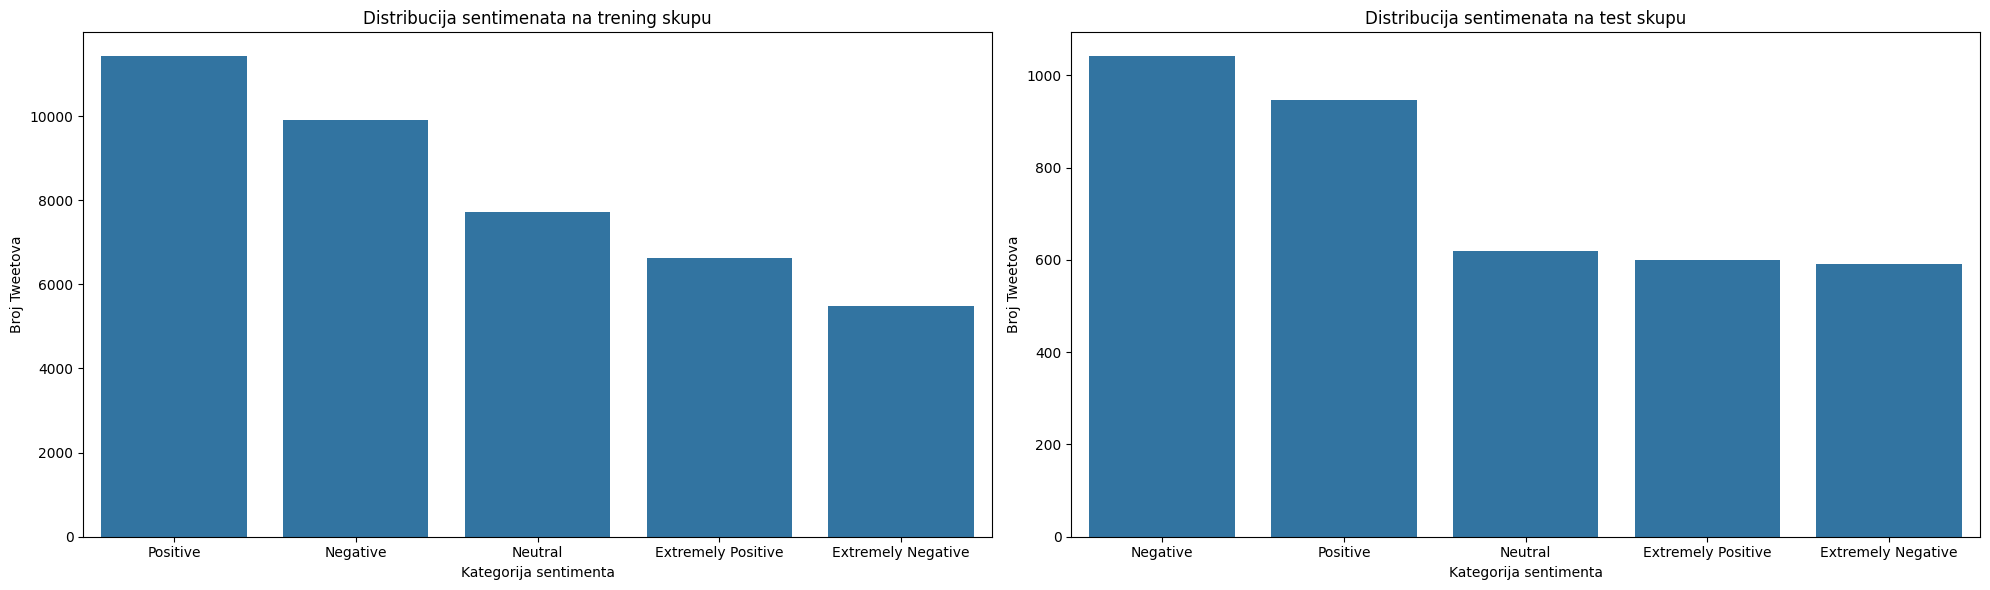

In [6]:
#ZADATAK: Provjerite broj ponavljanja svake od kategorija tweetova te ih prikažite na grafu koristeći prikladne biblioteke

fig, axes = plt.subplots(1, 2, figsize=(20, 6))

sns.countplot(ax=axes[0],
              data=selected_features_train,
              x='Sentiment',
              order=selected_features_train['Sentiment'].value_counts().index)
axes[0].set_title('Distribucija sentimenata na trening skupu')
axes[0].set_xlabel('Kategorija sentimenta')
axes[0].set_ylabel('Broj Tweetova')

sns.countplot(ax=axes[1],
              data=selected_features_test,
              x='Sentiment',
              order=selected_features_test['Sentiment'].value_counts().index)
axes[1].set_title('Distribucija sentimenata na test skupu')
axes[1].set_xlabel('Kategorija sentimenta')
axes[1].set_ylabel('Broj Tweetova')

plt.tight_layout()
plt.show()

In [7]:
mapping = {
    'Positive': 'Positive',
    'Extremely Positive': 'Positive',
    'Negative': 'Negative',
    'Extremely Negative': 'Negative',
    'Neutral': 'Neutral'
}

selected_features_train['Sentiment'] = selected_features_train['Sentiment'].map(mapping)
selected_features_test['Sentiment'] = selected_features_test['Sentiment'].map(mapping)

#ZADATAK: Prikažite broj primjeraka u svakoj klasi nakon mapiranja

print("Broj primjeraka u svakoj klasi u trening skupu nakon mapiranja:")
print(selected_features_train['Sentiment'].value_counts())

print("\nBroj primjeraka u svakoj klasi u testnom skupu nakon mapiranja:")
print(selected_features_test['Sentiment'].value_counts())

Broj primjeraka u svakoj klasi u trening skupu nakon mapiranja:
Sentiment
Positive    18046
Negative    15398
Neutral      7713
Name: count, dtype: int64

Broj primjeraka u svakoj klasi u testnom skupu nakon mapiranja:
Sentiment
Negative    1633
Positive    1546
Neutral      619
Name: count, dtype: int64


/tmp/ipython-input-3127221094.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_features_train['Sentiment'] = selected_features_train['Sentiment'].map(mapping)
/tmp/ipython-input-3127221094.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_features_test['Sentiment'] = selected_features_test['Sentiment'].map(mapping)


### c) Lematizacija i čišćenje teksta

In [8]:
def clean_text(text):
    # Lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+', '', text)
    # Remove mentions
    text = re.sub(r'@\w+', '', text)
    # Remove punctuation and numbers
    text = re.sub(r'[^a-z\s]', '', text)
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [9]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
  #ZADATAK: Napišite funkciju za lematizaciju teksta
    words = text.split()
    lemmatized_words = [lemmatizer.lemmatize(w) for w in words]
    return " ".join(lemmatized_words)

selected_features_train['clean_tweet'] = (
    selected_features_train['OriginalTweet']
    .apply(lemmatize_text)
    .apply(clean_text)
)

selected_features_test['clean_tweet'] = (
    selected_features_test['OriginalTweet']
    .apply(lemmatize_text)
    .apply(clean_text)
)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
/tmp/ipython-input-861899894.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_features_train['clean_tweet'] = (
/tmp/ipython-input-861899894.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_features_test['clean_tweet'] = (


### d) Pretvaranje teksta u vektore značajki (TF-IDF)

TF-IDF (Term Frequency–Inverse Document Frequency) je statistička metoda koja se koristi u obradi prirodnog jezika i pretraživanju informacija za procjenu koliko je određena riječ važna za jedan dokument u odnosu na veću zbirku dokumenata. TF-IDF kombinira dvije komponente:
1. Frekvencija pojma (TF): Mjeri koliko se puta riječ pojavljuje u dokumentu. Veća učestalost sugerira veću važnost. Ako se neki pojam često pojavljuje u dokumentu, vjerojatno je relevantan za sadržaj tog dokumenta.
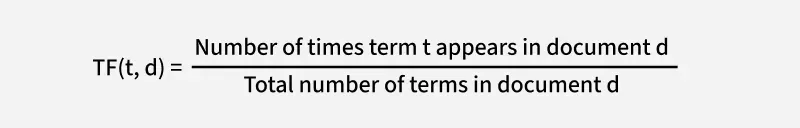

2. Obrnuta frekvencija dokumenta (IDF): Smanjuje težinu uobičajenih riječi koje se pojavljuju u više dokumenata, dok povećava težinu rijetkih riječi. Ako se pojam pojavljuje u manjem broju dokumenata, veća je vjerojatnost da je značajan i specifičan.
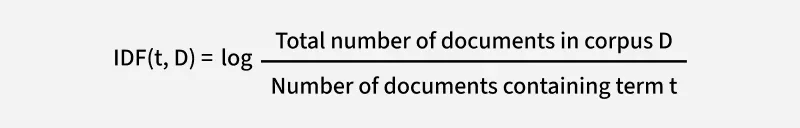

Ova ravnoteža omogućuje TF-IDF-u da istakne pojmove koji su i učestali unutar određenog dokumenta i prepoznatljivi u odnosu na ostatak zbirke dokumenata, što ga čini korisnim alatom za zadatke poput rangiranja pretraživanja, klasifikacije teksta i izdvajanja ključnih riječi.

In [10]:
tfidf = TfidfVectorizer(stop_words='english', max_features=5000)

X_train = tfidf.fit_transform(selected_features_train['clean_tweet'])
#ZADATAK: Transformirati očišćene tekstualne tweetove u numeričku TF-IDF reprezentaciju na testnom skupu.
X_test = tfidf.fit_transform(selected_features_test['clean_tweet'])

### e) Enkodiranje oznaka

In [11]:
le = LabelEncoder()

print(selected_features_train['Sentiment'].unique())

y_train = le.fit_transform(selected_features_train['Sentiment'])
y_test = le.transform(selected_features_test['Sentiment'])

y_train = pd.DataFrame(y_train, columns=['Sentiment'])
y_test = pd.DataFrame(y_test, columns=['Sentiment'])
y_train.head()

['Neutral' 'Positive' 'Negative']


,Sentiment
0,1
1,2
2,2
3,2
4,0


## 4. Treniranje modela - Naive Bayes

In [12]:
param_grid = {'alpha': [0.1, 0.5, 1.0, 2.0]}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(MultinomialNB(), param_grid, cv=skf, scoring='accuracy')
grid.fit(X_train, y_train)

print("Best alpha:", grid.best_params_)
print("Best cross-val accuracy:", grid.best_score_)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

Best alpha: {'alpha': 0.1}
Best cross-val accuracy: 0.6764586498292324


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

In [13]:
model = MultinomialNB(alpha = 0.1)
model.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MultinomialNB(alpha=0.1)

## 5. Evaluacija performansi

In [14]:
y_pred = model.predict(X_test)

print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=le.classes_))

print("Confusion Matrix:\n")
print(confusion_matrix(y_test, y_pred))

Classification Report:

              precision    recall  f1-score   support

    Negative       0.44      0.50      0.47      1633
     Neutral       0.22      0.05      0.09       619
    Positive       0.41      0.47      0.43      1546

    accuracy                           0.41      3798
   macro avg       0.35      0.34      0.33      3798
weighted avg       0.39      0.41      0.39      3798

Confusion Matrix:

[[820  59 754]
 [287  33 299]
 [767  59 720]]


## ZADATAK:
Trenirati model koristeći SVM i usporediti performanse s Naive Bayes-om.

In [15]:
y_train = selected_features_train['Sentiment']
y_test = selected_features_test['Sentiment']

In [16]:
nb = MultinomialNB()
nb.fit(X_train, y_train)

nb_pred = nb.predict(X_test)

print("=== Naive Bayes ===")
print("Accuracy:", accuracy_score(y_test, nb_pred))
print(classification_report(y_test, nb_pred))

=== Naive Bayes ===
Accuracy: 0.40179041600842547
              precision    recall  f1-score   support

    Negative       0.44      0.50      0.47      1633
     Neutral       0.18      0.10      0.13       619
    Positive       0.40      0.42      0.41      1546

    accuracy                           0.40      3798
   macro avg       0.34      0.34      0.34      3798
weighted avg       0.38      0.40      0.39      3798



In [17]:
svm = LinearSVC()
svm.fit(X_train, y_train)

svm_pred = svm.predict(X_test)

print("=== SVM (LinearSVC) ===")
print("Accuracy:", accuracy_score(y_test, svm_pred))
print(classification_report(y_test, svm_pred))

=== SVM (LinearSVC) ===
Accuracy: 0.40363349131121645
              precision    recall  f1-score   support

    Negative       0.44      0.52      0.48      1633
     Neutral       0.27      0.26      0.27       619
    Positive       0.41      0.34      0.37      1546

    accuracy                           0.40      3798
   macro avg       0.37      0.37      0.37      3798
weighted avg       0.40      0.40      0.40      3798



In [18]:
print("Naive Bayes accuracy: ", accuracy_score(y_test, nb_pred))
print("SVM accuracy: ", accuracy_score(y_test, svm_pred))

Naive Bayes accuracy:  0.40179041600842547
SVM accuracy:  0.40363349131121645


# Zadatak – samostalan rad na datasetu

### U ovom zadatku studenti će sami proći cijeli proces klasifikacije teksta koristeći metode strojnog učenja – od pripreme podataka do treniranja i usporedbe različitih modela.

Cilj je klasificirati opise proizvoda iz e-trgovine u jednu od četiri kategorije (Electronics, Household, Books, Clothing & Accessories).

### Koraci zadatka:

1. **Pregled dataseta**  
   - Preuzmite dataset „E-commerce Text Classification“ s Kaggle-a:  
     https://www.kaggle.com/datasets/saurabhshahane/ecommerce-text-classification  
   - Učitajte ga u Colab (npr. pomoću `pd.read_csv`)  
   - Prikažite osnovne informacije o datasetu

2. **Odabir značajki i čišćenje podataka**  
   - Provjerite i obradite nedostajuće vrijednosti
   - Uklonite duplikate ako postoje  
   - Po potrebi uravnotežite dataset (npr. undersampling/oversampling) – nije obavezno, ali je plus

3. **Predobrada teksta (čišćenje i lematizacija)**  
   - Pretvorite tekst u mala slova  
   - Uklonite HTML tagove, URL-ove, interpunkciju, brojeve, specijalne znakove  
   - Uklonite stop-riječi  
   - Provedite lematizaciju

4. **Pretvaranje teksta u vektore značajki**  
     - `TfidfVectorizer`
   - Podijelite podatke na train/test skup (80/20 ili 75/25)

5. **Enkodiranje oznaka (labela)**  
   - Pretvorite tekstualne kategorije u brojčane pomoću `LabelEncoder` ili `OneHotEncoder` (ovisno o modelu)

6. **Treniranje i usporedba modela**  
   
   
   Za svaki model:
   - Naučite model na trening skupu
   - Izmjerite performanse na test skupu: **accuracy, precision, recall, F1-score**
   - Nacrtajte **confusion matrix** i **classification report**
   - Ako stignete: Podesite hiperparametre (barem `GridSearchCV` ili `RandomizedSearchCV` na 2–3 parametra) za bolje rezultate

7. **Vizualizacija rezultata**  
   - Usporedite dva (ili više) modela u tablici i stupčastim grafom (accuracy, F1-score)
   
   - Ako koristite TF-IDF, pokažite 10–20 riječi s najvećim TF-IDF težinama po klasi (Iz riječi biste trebali zaključiti o kojoj klasi se radi)

8. **Zaključak i komentar rezultata**  
   - Koji model je bio bolji i zašto?
   - Koje su prednosti i nedostaci pristupa koje ste koristili?
   - Što biste još mogli isprobati da poboljšate rezultat (ideje za daljnje eksperimente)?
   - Koliko je predobrada teksta utjecala na performanse?


In [22]:
#1. Pregled dataseta
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

ecommerceData = pd.read_csv("/content/ecommerceDataset.csv")

ecommerceData.columns = ["Category", "Description"]

ecommerceData.head()
ecommerceData.shape
ecommerceData.info()
ecommerceData.isna().sum()
ecommerceData.duplicated().sum()

ecommerceData

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50424 entries, 0 to 50423
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Category     50424 non-null  object
 1   Description  50423 non-null  object
dtypes: object(2)
memory usage: 788.0+ KB


,Category,Description
0,Household,"SAF 'Floral' Framed Painting (Wood, 30 inch x ..."
1,Household,SAF 'UV Textured Modern Art Print Framed' Pain...
2,Household,"SAF Flower Print Framed Painting (Synthetic, 1..."
3,Household,Incredible Gifts India Wooden Happy Birthday U...
4,Household,Pitaara Box Romantic Venice Canvas Painting 6m...
...,...,...
50419,Electronics,Strontium MicroSD Class 10 8GB Memory Card (Bl...
50420,Electronics,CrossBeats Wave Waterproof Bluetooth Wireless ...
50421,Electronics,Karbonn Titanium Wind W4 (White) Karbonn Titan...
50422,Electronics,"Samsung Guru FM Plus (SM-B110E/D, Black) Colou..."


In [23]:
#2. Odabir značajki i čišćenje podataka
ecommerceData.dropna(inplace=True)
ecommerceData.drop_duplicates(inplace=True)

print('After dropna & duplicates, shape =', ecommerceData.shape)

ecommerceData

After dropna & duplicates, shape = (27801, 2)


,Category,Description
0,Household,"SAF 'Floral' Framed Painting (Wood, 30 inch x ..."
1,Household,SAF 'UV Textured Modern Art Print Framed' Pain...
2,Household,"SAF Flower Print Framed Painting (Synthetic, 1..."
3,Household,Incredible Gifts India Wooden Happy Birthday U...
4,Household,Pitaara Box Romantic Venice Canvas Painting 6m...
...,...,...
50401,Electronics,Micromax Bharat 5 Plus Zero impact on visual d...
50402,Electronics,Microsoft Lumia 550 8GB 4G Black Microsoft lum...
50406,Electronics,"Microsoft Lumia 535 (Black, 8GB) Colour:Black ..."
50407,Electronics,Karbonn Titanium Wind W4 (White) Karbonn Titan...


In [24]:
#3. Predobrada teksta (čišćenje i lematizacija)
import nltk
nltk.download('punkt_tab')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text, lower=True, remove_stopwords=True, lemmatize=True):
  if not isinstance(text, str):
    return ''
  if lower:
    text = text.lower()
    text = re.sub(r'<.*?>', ' ', text)
    text = re.sub(r'http\S+|www\.\S+', ' ', text)
    text = re.sub(r'[^a-z0-9\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()

  tokens = word_tokenize(text)
  if remove_stopwords:
    tokens = [t for t in tokens if t not in stop_words]
  if lemmatize:
    tokens = [lemmatizer.lemmatize(t) for t in tokens]

  return ' '.join(tokens)

print('\nCleaning text...')
ecommerceData['clean_text'] = ecommerceData["Description"].apply(clean_text)

ecommerceData.head()

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.



Cleaning text...


,Category,Description,clean_text
0,Household,"SAF 'Floral' Framed Painting (Wood, 30 inch x ...",saf floral framed painting wood 30 inch x 10 i...
1,Household,SAF 'UV Textured Modern Art Print Framed' Pain...,saf uv textured modern art print framed painti...
2,Household,"SAF Flower Print Framed Painting (Synthetic, 1...",saf flower print framed painting synthetic 13 ...
3,Household,Incredible Gifts India Wooden Happy Birthday U...,incredible gift india wooden happy birthday un...
4,Household,Pitaara Box Romantic Venice Canvas Painting 6m...,pitaara box romantic venice canvas painting 6m...


In [25]:
#4. Pretvaranje teksta u vektore značajki
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

le = LabelEncoder()
ecommerceData["label"] = le.fit_transform(ecommerceData["Category"])
le.classes_

print("label")
print(ecommerceData["label"])

X_train, X_test, y_train, y_test = train_test_split(
ecommerceData["clean_text"],
ecommerceData["label"],
test_size=0.2,
random_state=42,
stratify=ecommerceData["label"]
)

tfidf = TfidfVectorizer(max_features=5000)
X_train_vec = tfidf.fit_transform(X_train)
X_test_vec = tfidf.transform(X_test)

label
0        3
1        3
2        3
3        3
4        3
        ..
50401    2
50402    2
50406    2
50407    2
50409    2
Name: label, Length: 27801, dtype: int64


In [26]:
#5. Enkodiranje oznaka (labela)
tfidf = TfidfVectorizer(stop_words='english', max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print('TF-IDF shapes:', X_train_tfidf.shape, X_test_tfidf.shape)

TF-IDF shapes: (22240, 5000) (5561, 5000)



=== MultinomialNB ===
Accuracy: 0.932745909009171
F1 (weighted): 0.9325813126559577

Classification report:
                         precision    recall  f1-score   support

                 Books       0.97      0.88      0.92      1251
Clothing & Accessories       0.95      0.97      0.96      1135
           Electronics       0.92      0.91      0.91      1062
             Household       0.91      0.95      0.93      2113

              accuracy                           0.93      5561
             macro avg       0.94      0.93      0.93      5561
          weighted avg       0.93      0.93      0.93      5561



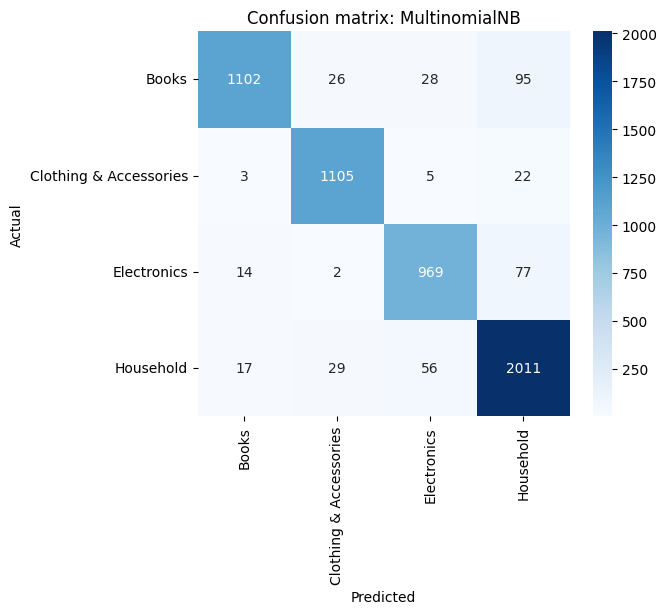


=== LinearSVC ===
Accuracy: 0.9564826470059342
F1 (weighted): 0.9564288425813248

Classification report:
                         precision    recall  f1-score   support

                 Books       0.97      0.94      0.95      1251
Clothing & Accessories       0.97      0.98      0.98      1135
           Electronics       0.94      0.94      0.94      1062
             Household       0.95      0.96      0.96      2113

              accuracy                           0.96      5561
             macro avg       0.96      0.95      0.96      5561
          weighted avg       0.96      0.96      0.96      5561



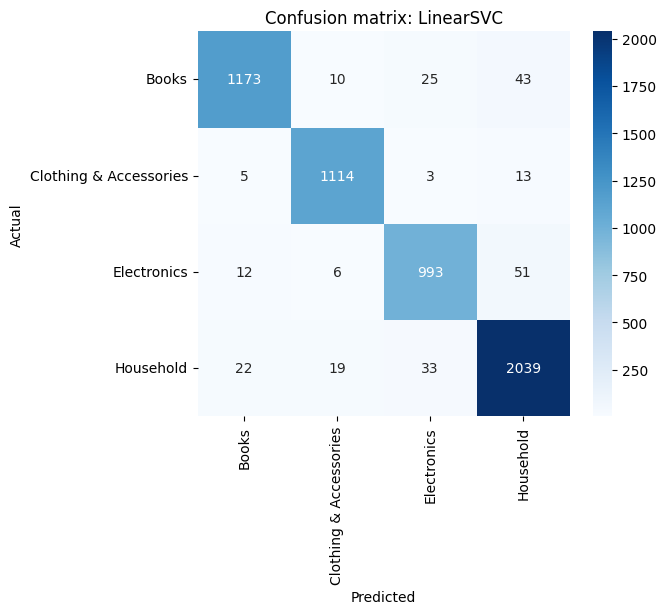

In [27]:
#6. Treniranje i usporedba modela
results = []

def evaluate_model(name, model, X_test, y_test):
  pred = model.predict(X_test)
  acc = accuracy_score(y_test, pred)
  f1 = f1_score(y_test, pred, average='weighted')
  print(f'\n=== {name} ===')
  print('Accuracy:', acc)
  print('F1 (weighted):', f1)
  print('\nClassification report:\n', classification_report(y_test, pred, target_names=le.classes_))
  cm = confusion_matrix(y_test, pred)
  plt.figure(figsize=(6,5))
  sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
  plt.title(f'Confusion matrix: {name}')
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.show()
  return {'model': name, 'accuracy': acc, 'f1_weighted': f1}

nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train)
res_nb = evaluate_model('MultinomialNB', nb, X_test_tfidf, y_test)
results.append(res_nb)

svm = LinearSVC()
svm.fit(X_train_tfidf, y_train)
res_svm = evaluate_model('LinearSVC', svm, X_test_tfidf, y_test)
results.append(res_svm)


Model comparison:
               accuracy  f1_weighted
model                               
MultinomialNB  0.932746     0.932581
LinearSVC      0.956483     0.956429


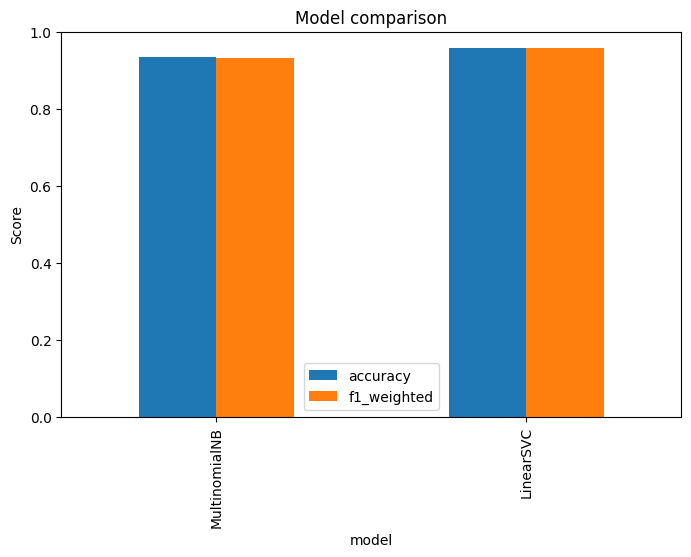

In [28]:
#7. Vizualizacija rezultata
res_df = pd.DataFrame(results).set_index('model')
print('\nModel comparison:')
print(res_df)


res_df.plot.bar(figsize=(8,5))
plt.title('Model comparison')
plt.ylabel('Score')
plt.ylim(0,1)
plt.show()

**1. Koji je model bio bolji i zašto?**

LinearSVC je bio bolji, ima i veći accuracy i veći F1-score. To znači da je precizniji u prepoznavanju klasa i manje griješi na rubnim slučajevima. SVC se  bolje snalazi s tekstom jer može razumijeti složenije odnose između riječi. MultinomialNB je brži i jednostavniji, ali njegova pretpostavka da su značajke međusobno neovisne često ograniči rezultat kod kompleksnijih tekstova.



**2. Prednosti i nedostaci pristupa koje smo koristili**

**MultinomialNB**

Prednosti: vrlo brz, lako se trenira, često daje dobre rezultate.

Nedostaci: slabije radi kad tekst nije jednostavan, ignorira odnose među riječima.

**LinearSVC**

Prednosti: odlično radi na TF-IDF vektorima, dobro podnosi puno značajki, daje stabilne i najčešće bolje rezultate.

Nedostaci: sporiji je za treniranje i finije podešavanje, treba malo više pažnje oko hiperparametara.


**3. Što još isprobati za poboljšanje rezultata?**

* Probati druge modele: Logistic Regression, Random Forest, ili modernije — npr. DistilBERT ili neki drugi manji Transformer.
* Povećati max_features u TF-IDF-u ili probati ukloniti vrlo rijetke riječi.
* Probati balansiranje klasa ako dataset nije ravnomjeran.
* Raditi GridSearch/RandomSearch za optimalne parametre (npr. C kod LinearSVC-a).

**4. Koliko je predobrada teksta utjecala na performanse?**

Predobrada je imala velik utjecaj. Uklanjanje šuma (URL-ovi, brojevi, nepotrebni znakovi) je pomoglo modelima da uče na stvarnom sadržaju, a ne na “smetnjama”. Lematizacija je smanjila broj različitih oblika riječi, što obično poboljša generalizaciju. TF-IDF dodatno naglašava bitne riječi, pa model lakše razlikuje klase.
